# Lab 6 - Multilabel Classification

Plan for today:

* familiarize ourselves with the problem of multilabel classification and metrics for such modelling
* implement two multilabel classification methods:
  * one-vs-all
  * embedding-based

**Attention!** We will work with [MS-COCO](https://cocodataset.org/) dataset today. It's pretty large, so we strongly recommend working with Colab today, since it'll be quicker to download the dataset there. 

In [ ]:
import json
from typing import List, Dict
import torch
from torch import nn
from torchvision.datasets import CocoDetection
from torchvision.models import vgg16, resnet34
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torchvision.models import vgg16

## 1 - The problem of Multilabel classification

In the problem of Multilabel classification, we would like to predict a **set** of labels for a given example.

**Question**: why do you think the softmax-based approach is not the best for this scenario?

**YOUR ANSWER HERE**

Multilabel solutions performance will also be measured a bit differently than in regular classification settings:

#### Precision

$$
  \frac{|y \cap \hat{y}|}{|\hat{y}|}
$$

#### Recall 

$$
  \frac{|y \cap \hat{y}|}{|y|}
$$

#### F1-score
* the harmonic average of precision and recall

### Task for you - please implement precision and recall for multilabel classification 



In [ ]:
def precision(y_true: torch.Tensor, y_pred: torch.Tensor) -> float:
  """
  Both y_true and y_pred should be tensors of ones and zeros of shape [B, C]
  denoting if an object of given class is or isn't present in the photo. 
  """
  ...

def recall(y_true: torch.Tensor, y_pred: torch.Tensor) -> float:
  """
  Both y_true and y_pred should be tensors of ones and zeros of shape [B, C]
  denoting if an object of given class is or isn't present in the photo. 
  """
  ...

## 2 - Data setup and exploration

Today we will work with the [COCO dataset](https://cocodataset.org/#home). Let's download it - in Colab it should take a couple of minutes:

In [ ]:
!wget http://images.cocodataset.org/zips/train2014.zip

In [ ]:
!unzip train2014.zip

In [ ]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip

In [ ]:
!unzip annotations_trainval2014.zip

In [ ]:
!wget http://images.cocodataset.org/zips/val2014.zip

In [ ]:
!unzip val2014.zip

In [ ]:
with open("annotations/instances_train2014.json") as f:
  annot = json.load(f)

categories_names = {
    c["id"]: c["name"]
    for c in annot["categories"]
}

In [ ]:
max([an["category_id"] for an in annot["annotations"] ])

90

COCO is an object detection dataset. However, today we will be only interested in labels of the objects present in the photos.

In [ ]:
def instances_to_multilabel_vector(instances: List[dict], vector_size: int = 91):
  vector = torch.zeros(vector_size)
  for i in instances:
    vector[i["category_id"]] = 1
  return vector

In [ ]:
train_set = CocoDetection(
    root="train2014", annFile="annotations/instances_train2014.json",
    target_transform=instances_to_multilabel_vector,
    transform=T.Compose([
            T.Resize(224),
            # Feel free to add augmentation!
            T.ToTensor(),
            T.Normalize(
              mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225],
          )
      ])
    )

val_set = CocoDetection(
    root="val2014", annFile="annotations/instances_val2014.json",
    target_transform=instances_to_multilabel_vector,
    transform=T.Compose([
            T.Resize(224),
            T.ToTensor(),
            T.Normalize(
              mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225],
          )
      ])
    )

loading annotations into memory...
Done (t=18.23s)
creating index...
index created!


Let's examine the data:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


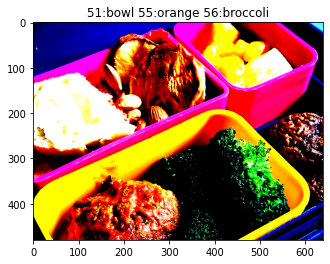

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


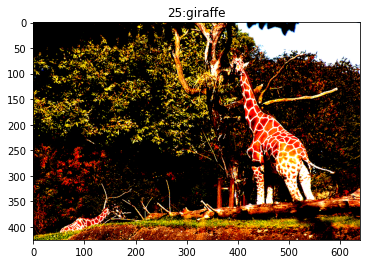

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


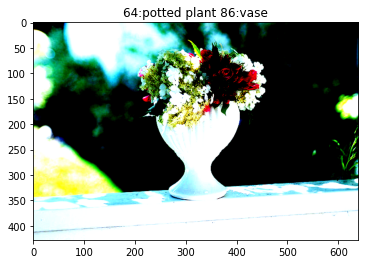

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


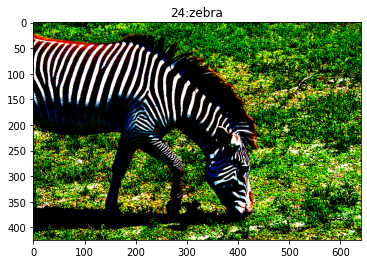

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


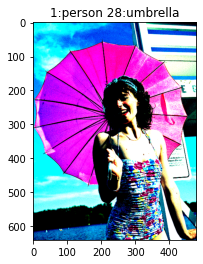

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


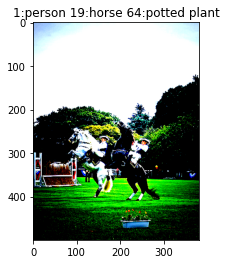

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


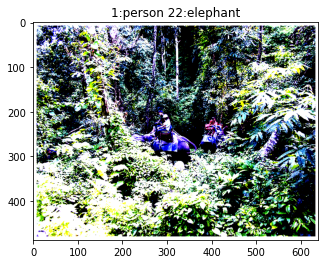

In [ ]:
for i, (X, y) in enumerate(train_set):

  plt.imshow(
      X.permute(1,2,0)
      # we're dealing with images transformed to tensors 
      # so in order to view them we need to permute them.
  )

  cats = [f"{i}:{categories_names[i]}" for i, oh in enumerate(y) if oh==1]
  plt.title(" ".join(cats))
  plt.show()

  if i > 5:
    break

When working with multilabel problems, it is often useful to analyze the data and see which labels tend to co-appear with one another. 

For example, humans may commonly appear together with dogs, but girraffes are unlikely to co-appear with umbrellas.

### Task for you - analyze the co-existence of labels

* go through the training dataset
* count the number of co-appearances of each **pair** of labels
* print the top-10 most commonly co-appearing label pairs, along with their class IDs and names (names are provided in the `categories_names` dict)
* you can also draw a heatmap of all co-occurences
* **note** - please avoid redundancy - e.g. if you count appearances of the `(A, B)` pair, you don't need to also count appearances of the `(B, A)` pair.


In [1]:
# YOUR CODE HERE

## 2 - One-vs-all classification

One way to approach multi-label classification is to treat it as $N$ binary classifications - take a model which outputs $N$ labels, but instead of applying $softmax$ as the final activation, applies $sigmoid$ function.

We can train such models with the [BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html).

### Task for you - train a model with one-vs-all method
* report the previously implemented precision and recall on the validation set throughout the training
* note that the grond-truth label vectors and output label vectors must hve the same dimentionality (91).
* note that precision and recall expect the vectors of `0`'s and `1`'s - therefore, when calculating those metrics, you need to transform the sigmoid output to such format!

**Hint**:

In order to simplify the training, you can take a pre-trained model from torchvision, e.g. VGG or ResNet and replace it's final layer with a linear layer with the appropriate number of classes (91), followed by sigmoid. 


In [ ]:
model = vgg16(pretrained=True)
model.classifier[-1] = nn.Sequential(
    nn.Linear(model.classifier[-1].in_features, 91),
    nn.Sigmoid()
)


In [ ]:
# YOUR CODE WITH THE TRAINING LOOP SHOULD GO HERE

## 3 - Taking advantage of class correlations

The sigmoid classifies each label **separately**. Even though it's internal features may in practice learn to associate two labels together, we can force it to do this explicitly.

For this approach we'll need 3 networks:
* $F_X$ - transforms images $x$ into embeddings $E_X$
* $F_Y$ - transforms label vectors $y$ into embeddings $E_Y$
* $F_D$ - transforms embeddings $E_X$ into predictions $Y_p$

The embeddings $E_X$ and $E_Y$ are of equal latent dimentionality $l$, possibly lower than $c$ (number of classes).


The models will optimize the sum of three loss functions:

1. We want the embeddings of pictures with a set of labels to be similiar to the mebeddings of that set of labels: 
$$
L1 = \|F_X(x) - F_Y(y) \|^2 =\\ 
\|E_X - E_Y\|^2
$$

2. We want the embeddings to be ortonormal (lengths of 1 and each pair of embedding vectors should be orthogonal to one another).

$$
L2 = \|F_X(X)F_X(X)^T - I\|^2 + \|F_Y(Y)F_Y(Y)^T - I\|^2  = \\
\|E_X E_X^T - I \|^2 + \|E_Y E_Y^T - I \|^2
$$

where $I \in \mathbb{R}^{l \times l} $ (see Eq. 2 of [this paper](https://www.aaai.org/ocs/index.php/AAAI/AAAI17/paper/viewFile/14166/14487) ).

3. We want to decode the predicted labels from the embeddings:

$$
L3 = \| F_D(F_X(x)) - y \|^2 = \\
\| F_D(E_X) - y \|^2
$$

By minimizing $L1 + L2$, we obtain **C**anonical **C**orrelation **A**nalyis. Minimizing $L3$ lets us decode the obtained embeddings.

### Task for you - train a model with the embedding-based method

* implement $L1, L2, L3$ losses and the training loop
* report the previously implemented precision and recall on the validation set throughout the training
* for obtaining embeddings, use the same kind of model as before, but replace the final layer with linear layer with your chosen embedding size
* networks $F_Y$ and $F_D$ should be sequences of a couple of linear layers

In [ ]:
def l1(e_x, e_y):
  """
  e_x, e_y: tensors of shape [b, embedding_size]
  """

  # YOUR CODE HERE

def l2(e_x, e_y):

  # YOUR CODE HERE

def l3(y_true, y_pred):
  # YOUR CODE HERE

In [ ]:
# YOUR CODE WITH THE TRAINING LOOP SHOULD GO HERE